# SetUp

Version requirements for the packages.

In [ ]:
# tensorflow==2.10.0
# Cython==0.29.32
# numpy==1.21.6
# matplotlib==3.2.2
# seaborn==0.11.2
# scipy==1.7.3
# scikit-learn==1.0.2
# scikit-image==0.18.3
# pandas==1.3.5
# pyyaml==6.0
# imutils==0.5.4
# opencv-python==4.6.0.66
# tqdm==4.64.1
# psutil==5.4.8
# h5py==3.1.0

Let's install all the packages that we are going to use

In [ ]:
# If we are running on google colab we need to install tensorflow 2.10.0
!pip install tensorflow==2.10.0

# Data split in training - validation - test
!pip install split-folders

# Cutmix
!pip install opencv-python

#Keras tuner
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 18 kB/s 
     |████████████████████████████████| 5.9 MB 50.3 MB/s 
     |████████████████████████████████| 1.7 MB 42.8 MB/s 
     |████████████████████████████████| 438 kB 66.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [ ]:
# Import of all the libraries and check the versions
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers.experimental import RandomFourierFeatures
import shutil
import splitfolders
import math
import glob # To parse filenames
import cv2 # Opencv
from sklearn.utils import class_weight
import keras_tuner
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from keras.utils.data_utils import get_file

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(np.__version__)
print(mpl.__version__)
print(sns.__version__)


2.10.0
1.21.6
3.2.2
0.11.2


In [ ]:
# Check which GPU is running
!nvidia-smi

Mon Nov 28 16:47:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
 # Suppress warnings
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Download the dataset and put it in the Temp directory
if os.path.isdir('Temp')==False:
  os. mkdir("Temp")
dataset_path = get_file(
            'dataset.zip',
            'https://drive.google.com/uc?export=download&id=1-28GxPTpFsCWfTmyjZJF21xzZB-MVA48&confirm=t',
            cache_dir="Temp")

# and extract the zip file in the content directory
!unzip Temp/datasets/dataset.zip

16503497/16503497 [==============================] - 1s 0us/step
Archive:  Temp/datasets/dataset.zip
   creating: training_data_final/Species1/
  inflating: training_data_final/Species1/00000.jpg  
  inflating: training_data_final/Species1/00001.jpg  
  inflating: training_data_final/Species1/00002.jpg  
  inflating: training_data_final/Species1/00003.jpg  
  inflating: training_data_final/Species1/00004.jpg  
  inflating: training_data_final/Species1/00005.jpg  
  inflating: training_data_final/Species1/00006.jpg  
  inflating: training_data_final/Species1/00007.jpg  
  inflating: training_data_final/Species1/00008.jpg  
  inflating: training_data_final/Species1/00009.jpg  
  inflating: training_data_final/Species1/00010.jpg  
  inflating: training_data_final/Species1/00011.jpg  
  inflating: training_data_final/Species1/00012.jpg  
  inflating: training_data_final/Species1/00013.jpg  
  inflating: training_data_final/Species1/00014.jpg  
  inflating: training_data_final/Species1/0001

# Dataset Preprocessing

## Overview

 We associate to each label an integer number.

In [ ]:

labels = ['Species1', #0
          'Species2', #1
          'Species3', #2
          'Species4', #3
          'Species5', #4
          'Species6', #5
          'Species7', #6
          'Species8' #7
      ]

We define our image dimensions

In [ ]:
input_shape = (96, 96, 3)

 If the folder is already present we remove it with all the content.

In [ ]:
if os.path.isdir('output'):
  shutil.rmtree('output')

Dataset split in train, validation and test sets.

In [ ]:
development_ratio = (.8,.1,.1) #used in the development phase, it includes a test set
submission_ratio = (.95,.05) #used at the end of the development in order to obtain the maximum accuracy

#take the dataset folder and split it in 'output' folder
splitfolders.ratio('training_data_final', output="output", seed=1337, ratio= development_ratio)

Copying files: 3542 files [00:00, 8541.37 files/s]


Plot example images from dataset.

In [ ]:
# Dataset folders
dataset_dir = 'output'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

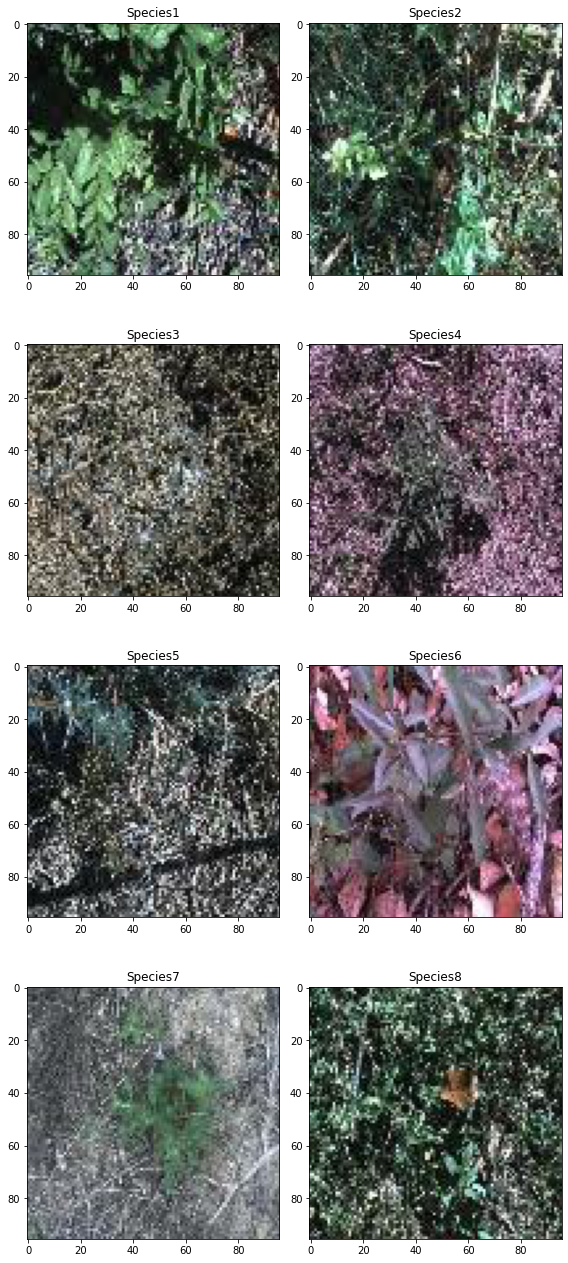

In [ ]:
num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Visualize the image distributions of the test train and validation folders

folder test:
Species1:20
Species2:54
Species3:52
Species4:52
Species5:54
Species6:23
Species7:55
Species8:52
folder train:
Species1:148
Species2:425
Species3:412
Species4:408
Species5:424
Species6:177
Species7:429
Species8:406
folder val:
Species1:18
Species2:53
Species3:51
Species4:51
Species5:53
Species6:22
Species7:53
Species8:50


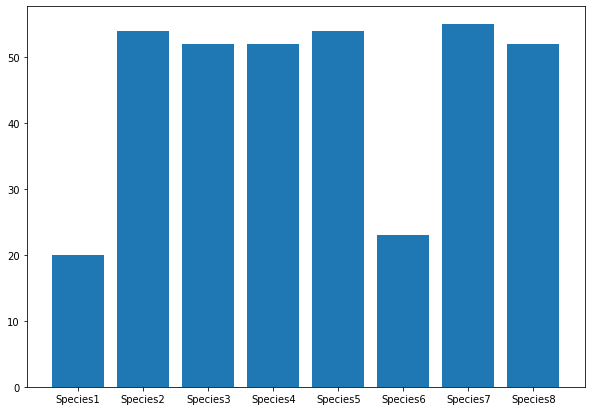

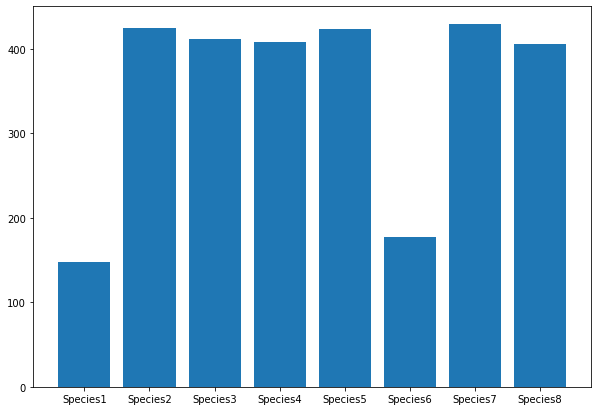

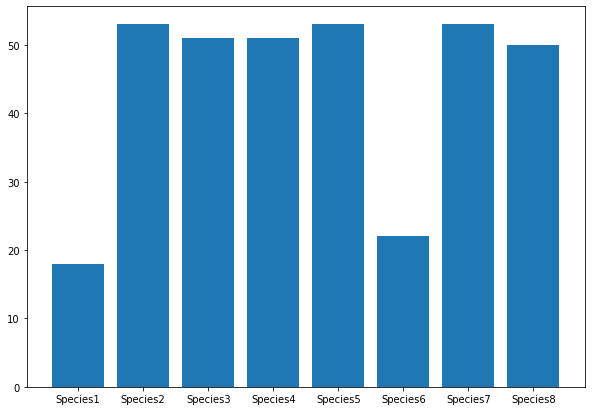

In [ ]:
for fold in ['test','train','val']:
  # Count for each set the number of instances for each class
  arr = [] # array containing the counts
  print("folder {}:".format(fold))
  for i in range(8):
    dir_path= "output/{}/Species{}".format(fold,i+1)
    cont = 0
    for path in os.listdir(dir_path):
      # check if current path is a file
      if os.path.isfile(os.path.join(dir_path, path)):
          cont += 1
    print("Species{}:{}".format(i+1,cont))
    arr.append(cont)

  fig = plt.figure(figsize=(10,7))
  plt.bar(labels, arr)

## Class Imbalance problem

As we can see the distribution of the classes is not balanced.

We want to equalize the training set distribution in order to obtain an uniform distribution.

Species1:148
Species2:425
Species3:412
Species4:408
Species5:424
Species6:177
Species7:429
Species8:406


<BarContainer object of 8 artists>

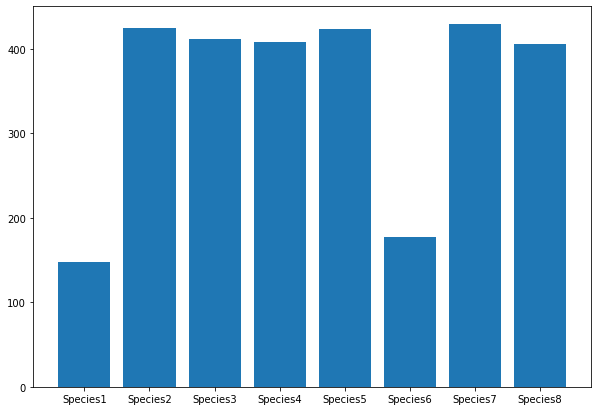

In [ ]:
arr = []
nmax = 0
for i in range(8):
  dir_path= "output/train/Species{}".format(i+1)
  cont = 0
  for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        cont += 1
  print("Species{}:{}".format(i+1,cont))
  arr.append(cont)
  if nmax < cont:
    nmax = cont

fig = plt.figure(figsize=(10,7))
plt.bar(labels, arr)


We can proceed in three ways:

1.   Class Weighting
2.   Downsampling
3.   Upsampling






### Class Weighting

First of all let's create a generator of training batches flowing from the dataset.

In [ ]:
# Create an instance of ImageDataGenerator
train_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_generator = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed
                                                       )

Found 2829 images belonging to 8 classes.


In [ ]:
# Compute the weights for each class that we are going to use in the fit method of the model
class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weights

array([2.38935811, 0.83205882, 0.85831311, 0.86672794, 0.83402123,
       1.99788136, 0.8243007 , 0.87099754])

### Downsampling

We have not explored this method as our dataset is not very large and with the downsampling we would have reduced its size further, affecting the accuracy.

### Upsampling

Our approach consists in duplicating random files for each species until we reach the maximum number of image of the most populated class, i.e. Species 7.

In [ ]:
# Class equalizator, we are going to duplicate random files for each species until we reach
#the maximum number of image of the most populated class -> Species7 with 537 images
for i in range(8):
  dir_path= "output/train/Species{}".format(i+1)
  cont = 0
  if arr[i]<nmax:
    random_files = []
    dim = arr[i]
    # Example: class 1 has 186 images, (537-186)/186 = 1.8, we must add duplicate
    #         the 186 images + the remaining 165-> 2 cycles (obtained with ceil(.))
    for j in range(math.ceil((nmax-dim)/arr[i])):
      # Random sample the number of files we need
      tmp = random.sample(os.listdir(dir_path),min(nmax-dim,arr[i]))
      dim += len(tmp)
      # Add one by one (probably there is an easier way)
      for f in tmp:
        random_files.append('{}_'.format(j+1)+f)
    # Copy the files in the folder with a prefix
    for file in random_files:
      shutil.copy2(dir_path+'/'+file[2:], dir_path+'/'+"Duplicated{}".format(file))
  for path in os.listdir(dir_path):
    # Check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        cont += 1
  print("Species{}:{}".format(i+1,cont))
  arr.append(cont)
  if nmax < cont:
    nmax = cont

Species1:429
Species2:429
Species3:429
Species4:429
Species5:429
Species6:429
Species7:429
Species8:429


Visualize the updated distribution

folder train:
Species1:429
Species2:429
Species3:429
Species4:429
Species5:429
Species6:429
Species7:429
Species8:429


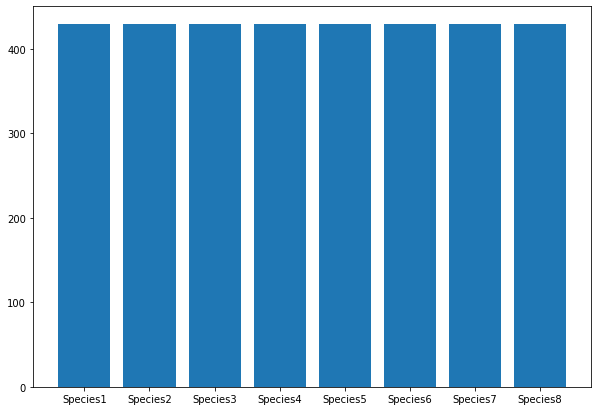

In [ ]:
for fold in ['train']:
  arr = []
  print("folder {}:".format(fold))
  for i in range(8):
    dir_path= "output/{}/Species{}".format(fold,i+1)
    cont = 0
    for path in os.listdir(dir_path):
      # check if current path is a file
      if os.path.isfile(os.path.join(dir_path, path)):
          cont += 1
    print("Species{}:{}".format(i+1,cont))
    arr.append(cont)

  fig = plt.figure(figsize=(10,7))
  plt.bar(labels, arr)


We have chosen Upsampling because is the method that has given us the best empirical results.



##Data Regularization

### Overview

Regularization helps us control our model capacity, ensuring that our models are better at making classifications on data points that they were not trained on, which we call the ability to generalize.

We have tried 3 types of data regularization techniques:


1.   Cutmix
2.   Patch Shuffle
3.   Data augmentation



### Patch Shuffle

Divide the image into patches of equal size and shuffle the pixels within each patch.

In [ ]:
#  Args:
#       - batch: batch of images
#       - patch_size: dimension of the squared patch, the image size must be divisible by the patch size
def patch_shuffle(batch,patch_size):
  images = batch[0]
  img_shape = images[0].shape
  #cycle all the images in tha batch
  for n in range(images.shape[0]):
    for i in range(int(img_shape[0] / patch_size)):
      for j in range(int(img_shape[0] / patch_size)):
        # extract a single patch of size patch_size * patch_size
        im = images[n,i*patch_size : i*patch_size + patch_size , j*patch_size : j*patch_size + patch_size , : ]
        # flatten in order to being able to shuffle the pixels
        im = np.reshape(im, (patch_size * patch_size, 3))
        np.random.shuffle(im)
        # reshape in squared dimension
        img = np.reshape(im, (patch_size,patch_size,3))
        # substitute the old pixels with newest ones
        images[n,i*patch_size : i*patch_size + patch_size , j*patch_size : j*patch_size + patch_size , : ] = img

This method did not give us improved accuracy and in the end we did not use it.

### CutMix

CutMix removes patches of image and replaces the removed regions with a patch from another image.

In [ ]:
plt.rcParams['figure.figsize'] = [10,10]

def rand_bbox(size, lamb):
    """ Generate random bounding box
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def generate_cutmix_image(batch, beta):
    """ Generate a CutMix augmented image from a batch
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    image_batch = batch[0]
    image_batch_labels = batch[1]
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape, lam)
    image_batch_updated = image_batch.copy()
    image_batch_updated[:, bbx1:bbx2, bby1:bby2, :] = image_batch[rand_index, bbx1:bbx2, bby1:bby2, :]

    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)

    batch_tranformed =[]
    batch_tranformed.append(image_batch_updated)
    batch_tranformed.append(label)

    return batch_tranformed


Let's create a custom generator for applying our preprocessing techniques

In [ ]:
class CustomGenerator():
    #  Args:
    #       - generator: a normal image generator
    #       - alpha: the parameter for the cutmix transformation
    #       - patch_shuffle: specify if you want to use the patch shuffle technique
    #       - patch_size: specify the dimension of the patch if patch_shuffle == True
    #       - cutmix: specify if you want to use the cutmix technique
    def __init__(self, generator, alpha=0.2,patch_shuffle = False,patch_size = None, cutmix = True):
        self.generator = generator #
        self.batch_size = generator.batch_size
        self.alpha = alpha
        self.shuffle = generator.shuffle
        self.patch_size = patch_size
        self.patch_shuffle = patch_shuffle
        self.cutmix = cutmix


    def __call__(self):
        while True:
            itr_num = len(self.generator)

            for i in range(itr_num):
                X, y = self.__data_generation()

                yield X, y

    def __data_generation(self):
        # obtain a batch from the normal generator
        batch = next(self.generator)
        if self.cutmix:
            # apply cutmix transformation to the batch
            batch = generate_cutmix_image(batch,self.alpha)
        if self.patch_shuffle:
            # apply patch shuffle transformation to the batch
            patch_shuffle(batch,patch_size = self.patch_size)
        #return the updated batch
        return batch[0], batch[1]


Visualize some images

In [ ]:
mixup_data_gen = ImageDataGenerator(
          rescale=1/255.
          )

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
mixup_gen = mixup_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
mixup_gen = CustomGenerator(mixup_gen, alpha=1.0, patch_shuffle = False, cutmix = True)()

Found 3432 images belonging to 8 classes.


Original Images


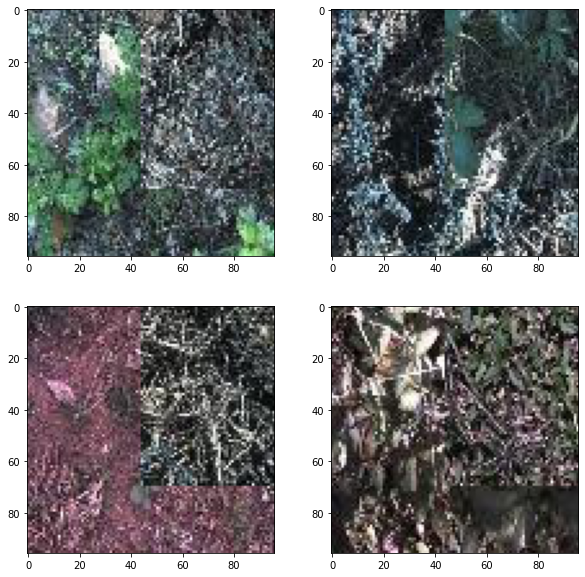

CutMix Images


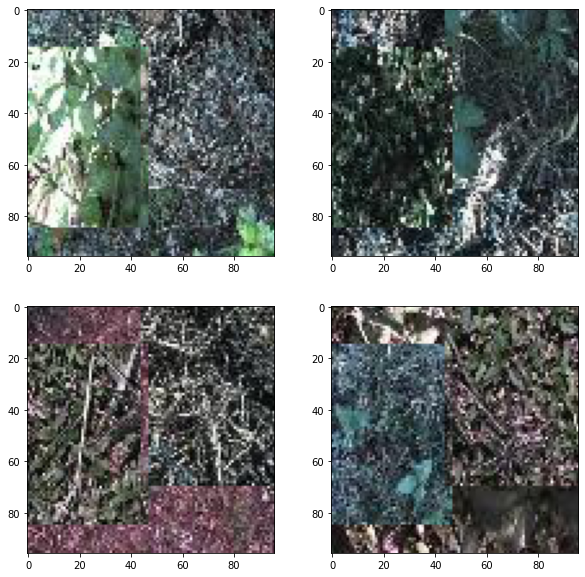

Original labels:
[[0.        0.        0.        0.6050347 0.3949653 0.        0.
  0.       ]
 [0.3949653 0.        0.        0.        0.6050347 0.        0.
  0.       ]
 [0.        0.        0.        0.        0.3949653 0.        0.
  0.6050347]
 [0.        0.        0.3949653 0.        0.        0.        0.
  0.6050347]
 [0.3949653 0.        0.        0.        0.6050347 0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.6050347
  0.3949653]
 [0.        0.        0.6050347 0.        0.        0.        0.
  0.3949653]
 [0.3949653 0.        0.        0.        0.6050347 0.        0.
  0.       ]
 [0.6050347 0.        0.        0.        0.        0.        0.
  0.3949653]
 [0.        0.        0.        0.        0.        0.6050347 0.3949653
  0.       ]
 [0.        0.        0.3949653 0.        0.6050347 0.        0.
  0.       ]
 [0.6050347 0.        0.        0.        0.3949653 0.        0.
  0.       ]
 [0.3949653 0.        0.6050347 0

In [ ]:
# Generate CutMix image
# Let's use the first image of the batch as the input image to be augmented
image_batch = next(mixup_gen)
image_batch_labels = image_batch[1]
image_batch_updated, image_batch_labels_updated = generate_cutmix_image(image_batch, 2.0)

# Show original images
print("Original Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        plt.imshow(image_batch[0][2*i+j])
plt.show()


# Show CutMix images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        plt.imshow(image_batch_updated[2*i+j])
plt.show()

# Print labels
print('Original labels:')
print(image_batch_labels)
print('Updated labels')
print(image_batch_labels_updated)

### Data augmentation

Data augmentation is a technique to increase the diversity of our training set by applying random (but realistic) transformations in order to increase the generalization ability of our model.

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_data_gen = ImageDataGenerator(
                                        rotation_range=360, # apply a random rotation to the image
                                        height_shift_range=20, #shift the height up to 20 pixels
                                        width_shift_range=20, #shift the width up to 20 pixels
                                        zoom_range=0.3, # zoom randomly the images
                                        shear_range=15, # apply a homography to the images
                                        horizontal_flip=True, # random horizontal flip the images
                                        vertical_flip=True, # random vertical flip of the images
                                        #fill_mode = 'reflect',
                                        brightness_range = [0.7,1.4], # modify the brightness of the images
                                        fill_mode='constant', # for visualization purposes
                                        cval = 0,
                                        rescale=1/255. # rescale value is multiplied to the images
                                        )

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_gen = aug_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed
                                                       )

Found 3432 images belonging to 8 classes.


Visualize 8 random augmented images

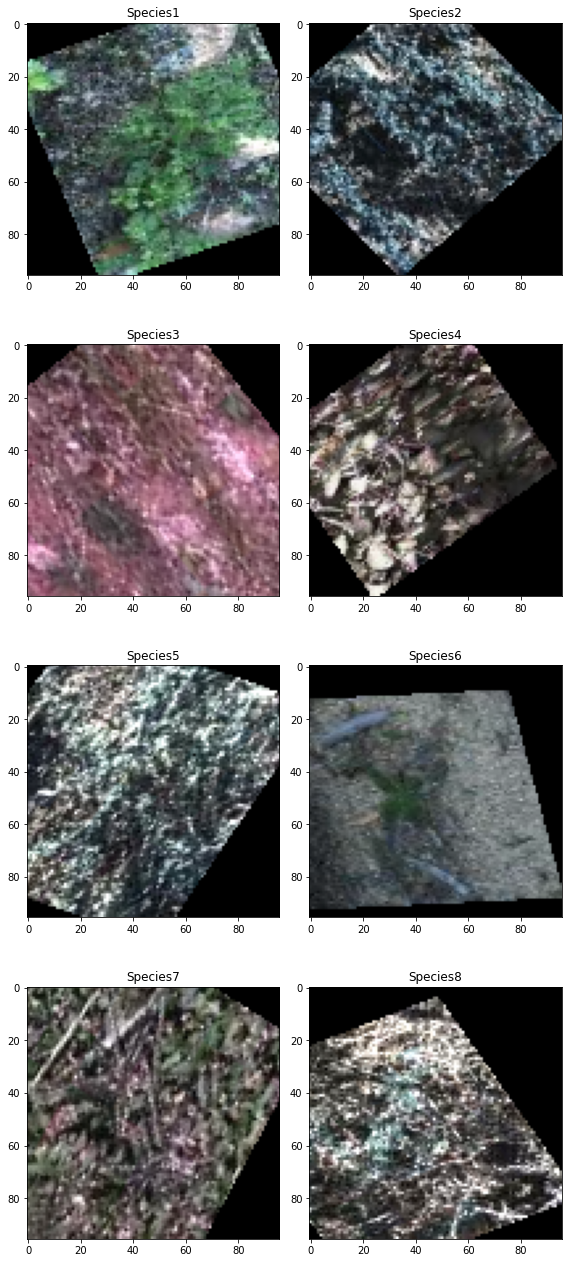

In [ ]:
batch_prova = next(aug_gen)
num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
  if i < 8:
    img = batch_prova[0][i]
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

### Final Generators

Define the batch size of the generator that corresponds with the batch size of the training.

In [ ]:
batch_size = 8

Training generator

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(
                                        rotation_range=360,
                                        height_shift_range=20,
                                        width_shift_range=20,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode = 'reflect',
                                        brightness_range = [0.7,1.4],
                                        )

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed
                                                       )
# Apply the cutmix
aug_train_gen_mixup = CustomGenerator(aug_train_gen, alpha=1.0, patch_shuffle=False,cutmix = True)()

Found 3432 images belonging to 8 classes.


In validation and test generators we don't apply regularization techniques because they must represent the final test set, we could only use a preprocessing function but in our case we don't need it.

In [ ]:
# Create an instance of ImageDataGenerator for training, validation, and test sets
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False, # we don't need to shuffle
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              shuffle=False,
                                              seed=seed)

Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


We can check the batch distribution that is uniform for the training.

<BarContainer object of 8 artists>

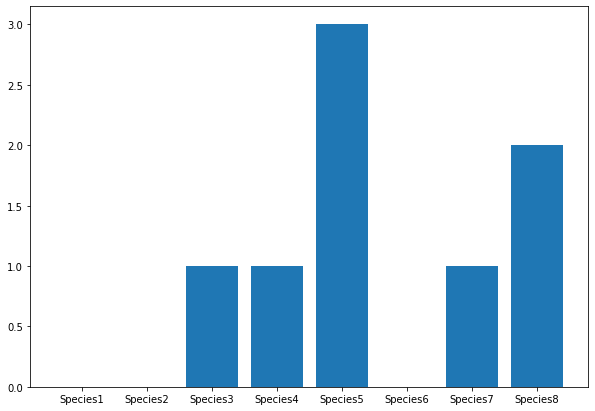

In [ ]:
#check batch distribution
batch = next(aug_train_gen)
arr = np.sum(batch[1],axis = 0)
fig = plt.figure(figsize=(10,7))
plt.bar(labels, arr)

# Training Phase

## Custom Network

Initially we tried to develop a custom network without Transfer Learning using Residual Blocks.

Define the residual block.

In [ ]:
#the residual block is made of 2 convolution layers with batch normalization after each of them
def residual_block(input, filter_num, kernel_dim, stride_dim, padding_type):
    y = tfkl.Conv2D(filters=filter_num,
               kernel_size=kernel_dim,
               strides=stride_dim,
               padding=padding_type)(input)

    relu1 = tfkl.ReLU()(y)
    bn = tfkl.BatchNormalization()(relu1)

    y2 = tfkl.Conv2D(filters=filter_num,
               kernel_size=kernel_dim,
               strides=stride_dim,
               padding=padding_type)(bn)
    #if the size of the input decreases in the residual block we add in the shortcut a convolution
    # layer followed by a batch normalization in order to have the same size at the output
    if input.shape != y2.shape:
      shortcut = tfkl.Conv2D(filters=filter_num,
               kernel_size=kernel_dim,
               strides=stride_dim,
               padding=padding_type)(input)
      shortcut = tfkl.BatchNormalization()(shortcut)
    else:
      shortcut = input

    #we add the shortcut
    add = tfkl.Add()([shortcut, y2])
    relu2 = tfkl.ReLU()(add)
    y = tfkl.BatchNormalization()(relu2)

    return y

Define the model.

In [ ]:
def model_definition(input_shape, num_classes):
  #filter definitions
  first_filter_dim = (3,3)
  first_filter_nun = 32
  filter_dim = [(3,3), (3,3), (3,3)]
  filter_num = [32, 64, 128]
  stride = 1
  padding = "same"
  max_pools = (2,2)

  # we start the network with a convolution layer
  input_layer = tfkl.Input(shape=input_shape, name='Input')
  conv = tfkl.Conv2D(filters=first_filter_nun,
               kernel_size=first_filter_dim,
               strides=stride,
               padding=padding)(input_layer)

  size = len(filter_num)
  residual_input = conv

  # we add 3 residual blocks
  for i in range(size):
    residual = residual_block(residual_input, filter_num[i], filter_dim[i], stride, padding)
    residual_input = tfkl.MaxPooling2D(max_pools)(residual)

  #after the res block we add another convolution layer followed by a GAP
  conv_final = tfkl.Conv2D(filters=filter_num[size-1],
               kernel_size=filter_dim[size-1],
               strides=stride,
               padding=padding)(residual_input)
  gap = tfkl.GlobalAveragePooling2D()(conv_final)

  # we end our net with a dense layer followed by the output layer
  dense = tfkl.Dense(128, activation="ReLU")(gap)
  output_layer = tfkl.Dense(8, activation='softmax')(dense)

  # Compile the model
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

  return model

Create the model and visualize it.

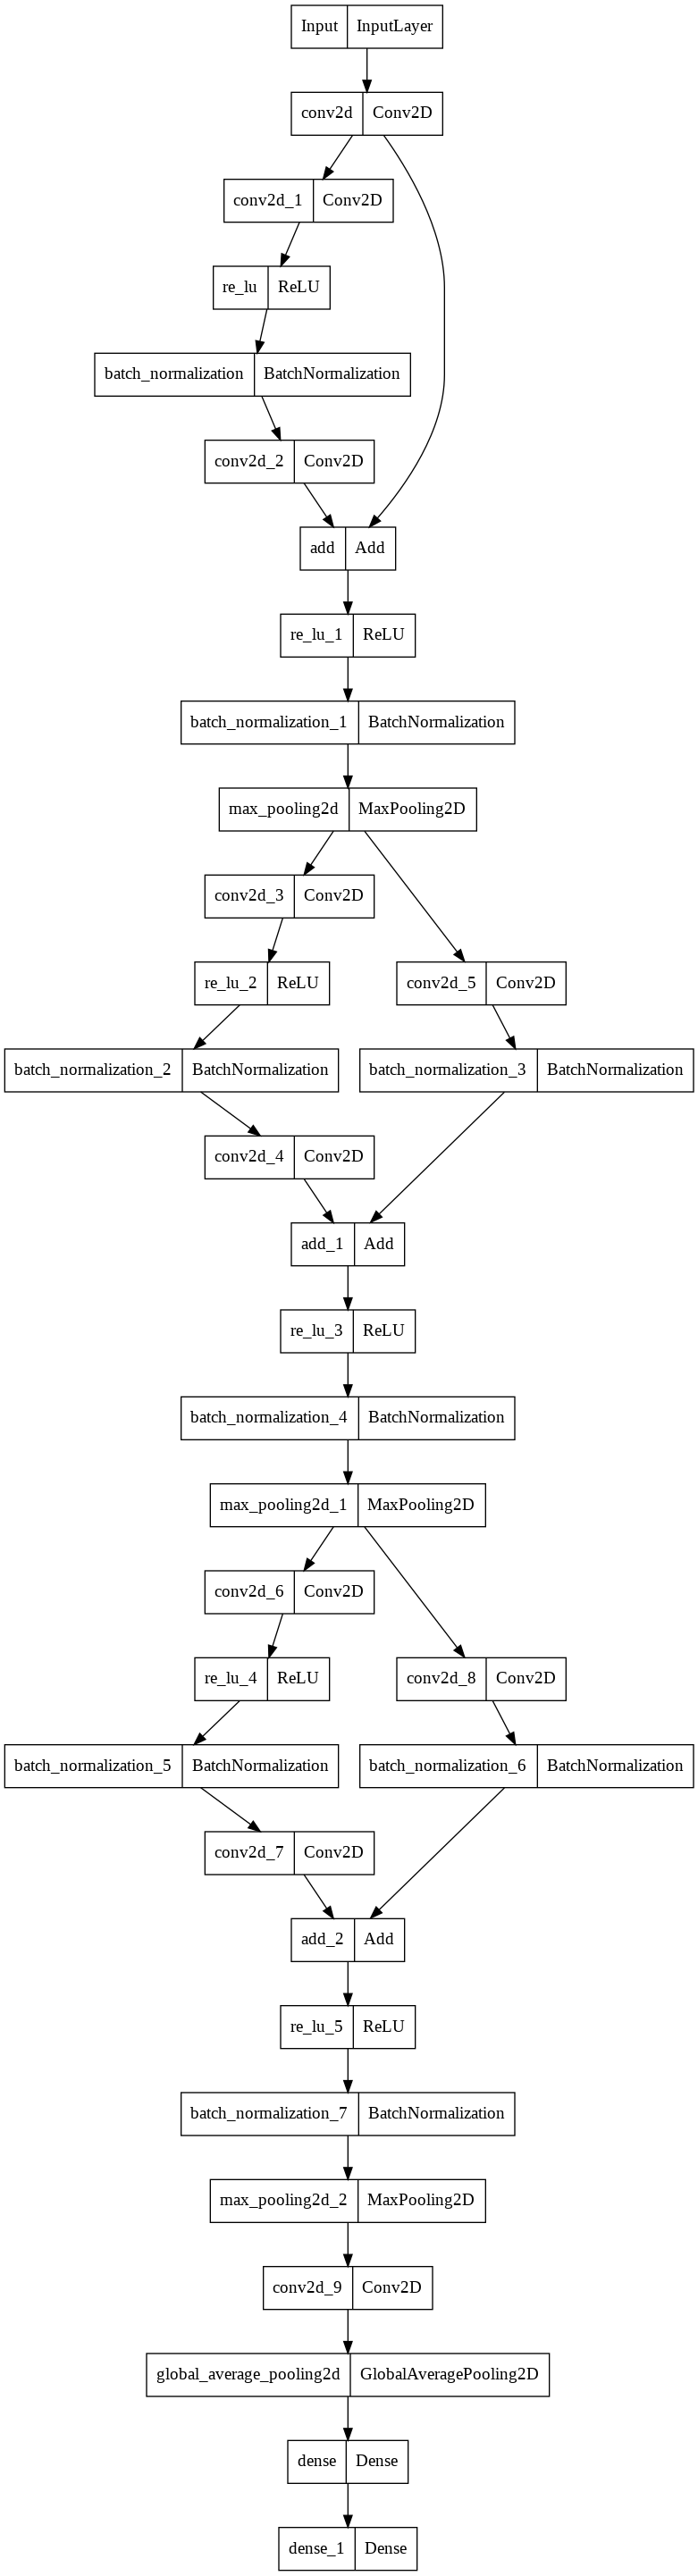

In [ ]:
input_shape = (96, 96, 3)
num_classes = 8

model = model_definition(input_shape, num_classes)
plot_model(model)

We have obtained a decent accuracy (>70%) with this network but it wasn't enough, so we proceed with the tranfer learning.

## Transfer Learning

We define the number of epochs.

In [ ]:
epochs = 200

We start from a well known pre trained model, ConvNextLarge.

785596384/785596384 [==============================] - 37s 0us/step


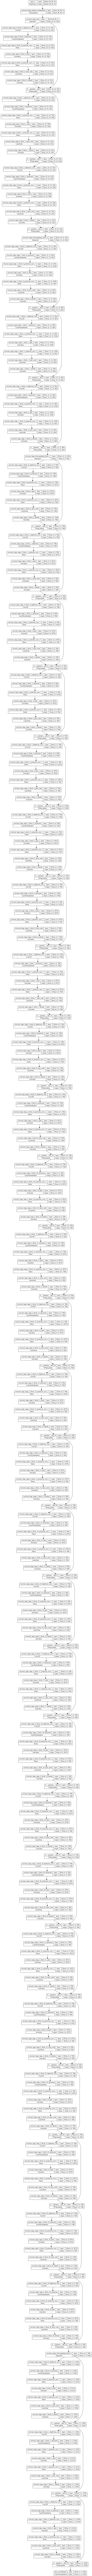

In [ ]:
# Download and plot the convnext model
supernet = tf.keras.applications.ConvNeXtLarge(
    include_top=False, # we don't include the network on top of the supernet
    weights="imagenet",
    input_shape=(96,96,3)
)
plot_model(supernet, to_file='supernet.png', show_shapes=True, show_layer_names=True)

We then define a custom on-top network.

In [ ]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=input_shape)

# training = False for the batch normalizations
x = supernet(inputs, training = False)

#GAP for regularization and shift invariance
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Quasi-SVM
x = RandomFourierFeatures(output_dim = 2048,scale = None, kernel_initializer="gaussian")(x)

x = tfkl.Dense(
    8,
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs,x, name='model')

# Compile the model
  # we use a high learning rate for the transfer learning phase because we need to learn the on top parameters from scratch
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-2), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 random_fourier_features (Ra  (None, 2048)             3147777   
 ndomFourierFeatures)                                            
                                                                 
 dense_2 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 199,394,505
Trainable params: 16,392
Non-traina

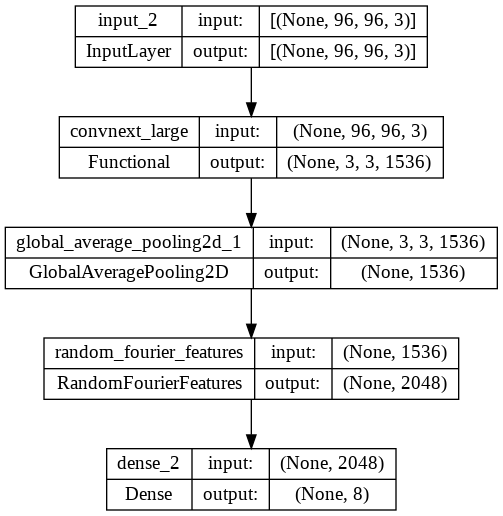

In [ ]:
plot_model(tl_model, to_file='supernet.png', show_shapes=True, show_layer_names=True)

Before fitting the model we need to define the callbacks.

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)

  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'),
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)

  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

We can now fit the model, in this phase we trained without the cutmix transformation.

In [ ]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_tl')

#Train the model - uncomment the lines below to train
# history = tl_model.fit(
#     x = aug_train_gen,
#     epochs = epochs,
#     validation_data = valid_gen,
#     callbacks = aug_callbacks,
# ).history

We can now save the model that we are going to use as a starting point for the Fine Tuning phase.

In [ ]:
tl_model.save("ConvNextLarge_TransferLearning")

## Fine Tuning

Define the model

In [ ]:
def get_model():
    # Download and plot the efficientNet model
    supernet = tf.keras.applications.ConvNeXtLarge(
        include_top=False,
        weights="imagenet",
        input_shape=(96,96,3)
    )

    # Use the supernet as feature extractor
    supernet.trainable = False

    inputs = tfk.Input(shape=(96,96,3))

    #training = False for the batch normalizations
    x = supernet(inputs, training = False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = RandomFourierFeatures(output_dim = 2048,scale = None, kernel_initializer="gaussian")(x)
    x = tfkl.Dense(
        8,
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(42))(x)


    # Connect input and output through the Model class
    model = tfk.Model(inputs,x, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')
    return model

We can either download the weights of an external pretrained model in Transfer Learning

In [ ]:
weights_path_TL = get_file(
            'ConvnextLargeTL.h5',
            'https://drive.google.com/uc?export=download&id=1y8QT2HNfwCdDZZBGIEFsqJcDvJws60GG&confirm=t',
            cache_dir="Temp")
ft_model = get_model()
ft_model.load_weights(weights_path_TL)

797955184/797955184 [==============================] - 17s 0us/step


Or load an existing model pre trained in Transfer Learning.

In [ ]:
#uncomment this line if you trained in this notebook
#ft_model = tf.keras.models.load_model("ConvNextLarge_TransferLearning")

Now we freeze (e.g. set untrainable) the first layers of the supernet and recompile the model.

In [ ]:
# visualize how many layers we can freeze
len(ft_model.get_layer('convnext_large').layers)

295

In [ ]:
# Freeze first N layers
N = 100
# Set the supernet trainable
ft_model.get_layer('convnext_large').trainable = True

for i, layer in enumerate(ft_model.get_layer('convnext_large').layers[:N]):
  layer.trainable=False
ft_model.summary()
# We use a much lower learning rate in this phase because we only need to fine tune the already trained weights
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 random_fourier_features_1 (  (None, 2048)             3147777   
 RandomFourierFeatures)                                          
                                                                 
 dense_3 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 199,394,505
Trainable params: 161,657,352
Non-t

At this point we are ready to fine tune the model with the train generator with the mixup transformation.

In [ ]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_ft')

#Train the model - uncomment the lines below to being able to train
  # we have to use the fit_generator function because we are using a custom generator
# history = ft_model.fit_generator(generator=aug_train_gen_mixup,
#                     steps_per_epoch=len(aug_train_gen),
#                     validation_data=valid_gen,
#                     epochs=epochs, verbose=1,
#                     callbacks=aug_callbacks).history

We can now save the model that we are going to use in the ensemble phase.

In [ ]:
ft_model.save("ConvNextLarge_FineTuning")

## Model Evaluation

In this phase we are going to evaluate a fully trained model.

In [ ]:
def get_final_model():
    # Download and plot the efficientNet model
    supernet = tf.keras.applications.ConvNeXtLarge(
        include_top=False,
        weights="imagenet",
        input_shape=(96,96,3)
    )

    # Use the supernet as feature extractor
    supernet.trainable = False

    inputs = tfk.Input(shape=(96,96,3))

    #training = False for the batch normalizations
    x = supernet(inputs, training = False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = RandomFourierFeatures(output_dim = 2048,scale = None, kernel_initializer="gaussian")(x)
    x = tfkl.Dense(
        8,
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(42))(x)


    # Connect input and output through the Model class
    model = tfk.Model(inputs,x, name='model')

    #freeze first 100 layers
    N = 100
    model.get_layer('convnext_large').trainable = True

    for i, layer in enumerate(model.get_layer('convnext_large').layers[:N]):
      layer.trainable=False

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')
    return model


First of all load the model.

In [ ]:
# uncomment the line below if you have trained on this notebook
#model = tf.keras.models.load_model("ConvNextLarge_FineTuning")

Or download the weights of our externally trained model

In [ ]:
weights_path_FT = get_file(
            'ConvnextLargeFT.h5',
            'https://drive.google.com/uc?export=download&id=1YrDi42g2eWsaKA2HeXspAN6ZjRyuDNfg&confirm=t',
            cache_dir="Temp")
ft_model = get_final_model()
ft_model.load_weights(weights_path_FT)

797955048/797955048 [==============================] - 17s 0us/step


Predict the test set, compute the confusion matrix and the classification metrics.

46/46 [==============================] - 21s 131ms/step
Accuracy: 0.9751
Precision: 0.9721
Recall: 0.9788
F1: 0.9751


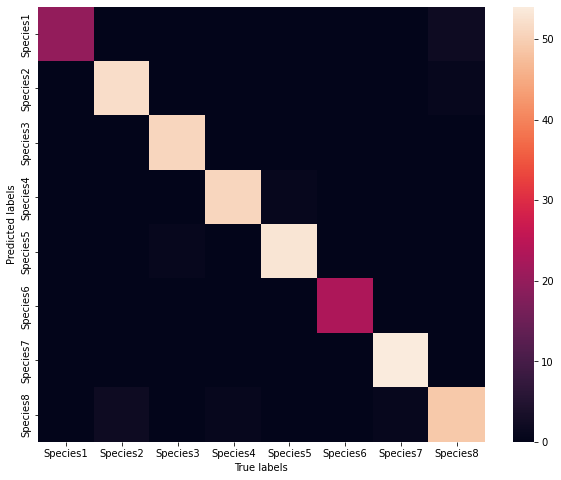

In [ ]:
y_test = test_gen.labels
predictions = ft_model.predict(test_gen)
# Compute the confusion matrix
cm = confusion_matrix(y_test, np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(y_test, np.argmax(predictions, axis=-1))
precision = precision_score(y_test, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(y_test, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(y_test, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels), yticklabels=list(labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Improvements

In order to improve the accuracy of our model we can use:

1.   Hyperparameter tuning
2.   Ensemble models
3.   Test Time Augmentation (not implemented in submitted model)



### HyperParameter Tuning

The most important part of the training is the hyperparameter tuning, in order to do so we used KerasTuner.

First tune the parameters of the on top network.

Define a model

In [ ]:
def build_top_model(hp):
  supernet = tf.keras.applications.ConvNeXtXLarge(
        include_top=False,
        weights="imagenet",
        input_shape=(96,96,3))

  # Use the supernet as feature extractor
  supernet.trainable = False

  inputs = tfk.Input(shape=input_shape)

  #training = False for the batch normalizations
  x = supernet(inputs, training = False)

  flattenlayer = hp.Boolean('flatten')
  if flattenlayer:
    x = tfkl.Flatten(name='Flattening')(x)
  else:
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

  RandomFourierFeatures(output_dim = hp.Choice('output_dim',[1024,2048,4086]),scale = hp.Choice('scale',[50,100,200,1000]),
                        kernel_initializer=hp.Choice('kernel',["gaussian","laplacian"]),
                        trainable = hp.Boolean("trainable"))(x)
  x = tfkl.Dense(
      8,
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


  # Connect input and output through the Model class
  ft_model = tfk.Model(inputs,x, name='model')

  # Compile the model
  ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-2), metrics='accuracy')
  return ft_model

Start the search of the parameters to find the best combinations.

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_top_model,
    objective='val_accuracy',
    overwrite=True,
    max_trials=20)

# number of epochs for each trial
epochs = 5
### uncomment the lines below to search
# tuner.search(aug_train_gen, epochs=epochs, validation_data=valid_gen)
# best_model = tuner.get_best_models()[0]

1393257616/1393257616 [==============================] - 64s 0us/step


Show the results of the parameters search.

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials


Then tune the number of layers to freeze

In [ ]:
def build_model(hp):
    freeze = hp.Choice("freeze",[100,150,200,250,300])
    if os.path.isdir('Temp')==False:
      os. mkdir("Temp")
    weights_path_TL = get_file(
            'ConvnextLargeTL.h5',
            'https://drive.google.com/uc?export=download&id=1y8QT2HNfwCdDZZBGIEFsqJcDvJws60GG&confirm=t',
            cache_dir="Temp")
    ft_model = get_model()
    ft_model.load_weights(weights_path_TL)

    N = freeze
    ft_model.get_layer('convnext_large').trainable = True

    for i, layer in enumerate(ft_model.get_layer('convnext_large').layers[:N]):
      layer.trainable=False


    ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
    return ft_model

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    overwrite=True,
    max_trials=7)

### uncomment the lines below to search
# tuner.search(aug_train_gen, epochs=5, validation_data=valid_gen)
# best_model = tuner.get_best_models()[0]
# tuner.results_summary()

### Ensemble models

In order to obtain the best model we ensembled 3 models of ConvNextLarge with N = 100 frozen layers with different batch size: 8, 16 and 32, trained with 95% of training set and 5% of validation set.

We define the class for performing a weighted average of the models.

In [ ]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, weights, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w = weights

    def call(self, inputs):
        result = 0
        for i in range(len(inputs)):
            result += self.w[i] * inputs[i]
        return result


For simplicity i don't duplicate the training phase for each model but i only download the pretrained weights because the only things that change are the size of the training set -> 95% and the batch sizes

In [ ]:

#we create the destination folder
if os.path.isdir('Temp')==False:
  os. mkdir("Temp")
weights_path_32 = get_file(
            'model32.h5',
            'https://drive.google.com/uc?export=download&id=1oOajiHc30pBzryh_zPwxuBrJXljaSlLE&confirm=t',
            cache_dir="Temp")
weights_path_16 = get_file(
            'model16.h5',
            'https://drive.google.com/uc?export=download&id=1_TpSyai2avhqrakioa0pQc3spOIkb15P&confirm=t',
            cache_dir="Temp")
weights_path_8 = get_file(
            'model8.h5',
            'https://drive.google.com/uc?export=download&id=1uh6Zay4EG3HM_l_l6agAKCD0zf37FV1I&confirm=t',
            cache_dir="Temp")

797955048/797955048 [==============================] - 15s 0us/step


We create the 3 models

In [ ]:
convnext8 = get_final_model()
convnext16 = get_final_model()
convnext32 = get_final_model()

We load the weights

In [ ]:
convnext8.load_weights(weights_path_8)
convnext16.load_weights(weights_path_16)
convnext32.load_weights(weights_path_32)

Combine the 3 models in 1.

In [ ]:
#change the names to avoid ambiguity
convnext8._name="ConvNext1"
convnext16._name="ConvNext2"
convnext32._name="ConvNext3"

models = [convnext8,convnext16,convnext32]
model_input = tf.keras.Input(shape=(96, 96, 3))
model_outputs = [model(model_input) for model in models]
#we use the same weight for all the models
ensemble_output =  WeightedAverageLayer([0.33,0.33,0.33])(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

This is our best model that gave us an accuracy of 93.03% on the private test set

Save the final model.

In [ ]:
ensemble_model.save("ensembleModel")

### Test Time Augmentation (TTA) (not implemented in submitted model)

For even better results we could use Test Time Augmentation, instead of showing the regular, “clean” images from the test set, only once to the trained model, we will show it the augmented images several times. We will then average the predictions of each corresponding image and take that as our final guess.

In [ ]:
# make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, n_examples):
    # convert image into dataset
    samples = np.array([image]*n_examples)
    # prepare iterator
    it = datagen.flow(samples, batch_size=n_examples)
    # make predictions for each augmented image
    yhats = model.predict_generator(it, steps=n_examples, verbose=0)

    # sum across predictions
    summed = np.sum(yhats, axis=0)

    # argmax across classes
    return np.argmax(summed)

In [ ]:
#take an example image
image = next(test_gen)[0][0]

#create a datagenerator with the transformations
datagen = ImageDataGenerator(
        rotation_range=360,
        height_shift_range=20,
        width_shift_range=20,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode = 'reflect',
)

#predict the class
tta_prediction(datagen, ensemble_model, image, 8)

0